Result of LTI poles estimation

May 01, 2019 
S.Ukai

* Compare the estimated poles with the true ones
* Check the parameter dependency of poles estimation error
	* Parameter: Nhrz(length of prediction horizon), Nepoch(number of epochs on training)
* Check which pole is difficult to estimate

In [1]:
import matplotlib.pylab as plt
import pickle
import sqlite3
from modules import *
conn = sqlite3.connect('db.sqlite')
cur = conn.cursor()

# Compare the estimated poles with the true ones:

* model_file_path: in which a model object restores
* lti_file_file: in which a data generator restores

In [2]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = 16
    and Training.Nepoch = 2048
    ''', ('./tmp/data_006.pk',))
model_file_path, Nhidden, lti_file_path, _, _ = cur.fetchone()

* A: true system matrix in state space model
* A_hat: estimated one

In [3]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
mdl = model001(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

_weight = mdl.xu2x.weight
weight = _weight.data.numpy()
A_hat = weight[:, :Nhidden]
A = data_generator.A

In [4]:
eig, _= np.linalg.eig(A)
eig_hat, _ = np.linalg.eig(A_hat)

* See a pair of distibution of eigenvalues of discrete time system:

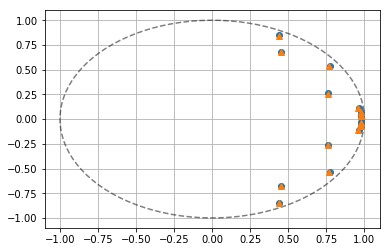

In [5]:
plt.plot(np.cos(2*np.pi*np.linspace(0,1,100)), np.sin(2*np.pi*np.linspace(0,1,100)), '--k', alpha=.5)
plt.plot(np.real(eig), np.imag(eig), 'o')
plt.plot(np.real(eig_hat), np.imag(eig_hat), '^')
plt.grid()

* See a pair of distibution of eigenvalues of continuous time system:

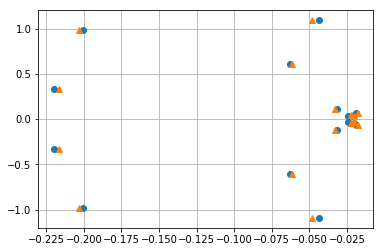

In [6]:
plt.plot(np.real(np.log(eig)), np.imag(np.log(eig)), 'o')
plt.plot(np.real(np.log(eig_hat)), np.imag(np.log(eig_hat)), '^')
plt.grid()

* Quantify the difference of the two distributions by using Wasserstein distance:

In [7]:
tmp_eig_cont = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), np.log(eig))]) # (*, 2)
tmp_eig_hat_cont = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), np.log(eig_hat))]) # (*, 2)
c = np.mean(np.abs(1 - tmp_eig_hat_cont.reshape((1, -1, 2)) / tmp_eig_cont.reshape((-1, 1, 2))), axis=2)

In [8]:
wdist, P = calc_wdist(c)
print("The distance between the two distributions is %8.2e." % wdist)

The distance between the two distributions is 3.99e-02.


c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


In [9]:
Nhidden * (P @ np.log(eig_hat))

array([-0.04846707+1.09113085j, -0.04846707-1.09113085j,
       -0.2029773 +0.98322242j, -0.2029773 -0.98322242j,
       -0.06186905+0.61011171j, -0.06186905-0.61011171j,
       -0.21642241+0.32689816j, -0.21642241-0.32689816j,
       -0.03306351+0.11662164j, -0.03306351-0.11662164j,
       -0.0204945 +0.03555232j, -0.0204945 -0.03555232j,
       -0.02225488+0.04172248j, -0.02225488-0.04172248j,
       -0.0176731 +0.06974776j, -0.0176731 -0.06974776j])

In [10]:
np.log(eig)

array([-0.04394236+1.0911572j , -0.04394236-1.0911572j ,
       -0.20085101+0.98395582j, -0.20085101-0.98395582j,
       -0.0628665 +0.60647845j, -0.0628665 -0.60647845j,
       -0.22006355+0.33141686j, -0.22006355-0.33141686j,
       -0.03196967+0.11520462j, -0.03196967-0.11520462j,
       -0.02433681+0.03450152j, -0.02433681-0.03450152j,
       -0.02055116+0.04469633j, -0.02055116-0.04469633j,
       -0.01925701+0.07013954j, -0.01925701-0.07013954j])

# Check the parameter dependency of poles estimation error

* db.sqlite contains the following data
* Trained model (its binary file path)
* Data generator (its binary file path)
* Training parameter
	* Nepoch varies over (2^7, 2^9, 2^11)
	* Nhrz varies over (2^0, 2^2, 2^4)

In [11]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    ''', ('./tmp/data_006.pk',))

tbl = []
for (model_file_path, Nhidden, lti_file_path, Nepoch, Nhrz) in cur.fetchall():
    with open(lti_file_path, "rb") as fp:
        data_generator = pickle.load(fp)
    Ny = data_generator.Ny
    Nu = data_generator.Nu
    mdl = model001(Nhidden, Ny, Nu)
    mdl.load_state_dict(torch.load(model_file_path))

    _weight = mdl.xu2x.weight
    weight = _weight.data.numpy()
    A_hat = weight[:, :Nhidden]
    A = data_generator.A

    wdist = check_spectrum(A, A_hat)
    tbl.append((Nepoch, Nhrz, wdist))

c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_ip.py:273: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
c:\users\shouta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\_linprog_ip.py:285: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)


* Summary:
	* Nepoch increases and then the estimated distribution closes to the true one.
	* Nhrz increases  and then the estimated distribution closes to the true one.

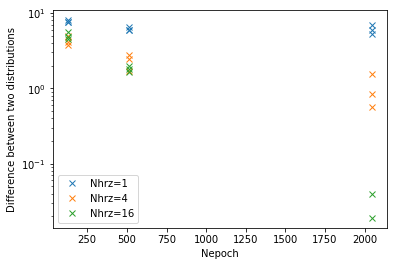

In [12]:
tbl = np.array(tbl)
plt.plot(tbl[tbl[:,1] == 2**0,0], tbl[tbl[:,1] == 2**0,2], 'x', label = 'Nhrz=1')
plt.plot(tbl[tbl[:,1] == 2**2,0], tbl[tbl[:,1] == 2**2,2], 'x', label = 'Nhrz=4')
plt.plot(tbl[tbl[:,1] == 2**4,0], tbl[tbl[:,1] == 2**4,2], 'x', label = 'Nhrz=16')
plt.legend()
plt.xlabel('Nepoch')
plt.ylabel('Difference between two distributions')
plt.yscale('log')
plt.show()

# Check which pole is difficult to estimate

* Quantify the difference of the two distributions by using Wasserstein distance:

In [13]:
# a: slave(to be matched), b: master(which is a basis)
def match_eig_dist_to_another(a, b):
    tmp_a = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), a)]) # (*, 2)
    tmp_b = np.array([*map(lambda xx: (np.real(xx), np.imag(xx)), b)]) # (*, 2)
    c = np.mean(np.abs(1 - tmp_a.reshape((1, -1, 2)) / tmp_b.reshape((-1, 1, 2))), axis=2)
    _, P = calc_wdist(c)
    a_matched = (P @ a)/np.sum(P, axis=1)
    return a_matched

## The best case: Nhrz = 2^4, Nepoch = 2^11

In [14]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = 16
    and Training.Nepoch = 2048
    ''', ('./tmp/data_006.pk',))
model_file_path, Nhidden, lti_file_path, _, _ = cur.fetchone()

* load model and data generator
* Calculate the estimated (matched) poles and the true one

In [15]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
mdl = model001(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

_weight = mdl.xu2x.weight
weight = _weight.data.numpy()
A_hat = weight[:, :Nhidden]
A = data_generator.A

eig, _= np.linalg.eig(A)
eig_hat, _ = np.linalg.eig(A_hat)

log_eig = np.log(eig)
log_eig_hat = np.log(eig_hat)
log_eig_hat_matched = match_eig_dist_to_another(log_eig_hat, log_eig)

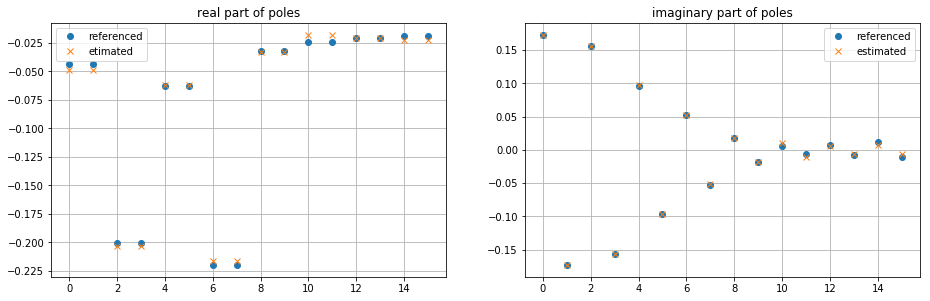

In [16]:
plt.figure(figsize=[40/2.57, 12/2.57])
plt.subplot(1,2,1)
plt.plot(np.real(log_eig), 'o', label = 'referenced')
plt.plot(np.real(log_eig_hat), 'x', label = 'etimated')
plt.title('real part of poles')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.imag(log_eig)/(2*np.pi), 'o', label='referenced')
plt.plot(np.imag(log_eig_hat)/(2*np.pi), 'x', label='estimated')
plt.title('imaginary part of poles')
plt.legend()
plt.grid()

## A sub best case: Nhrz = 2^4, Nepoch = 2^9

In [17]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = ?
    and Training.Nepoch = ?
    ''', ('./tmp/data_006.pk', 2**4, 2**9))
model_file_path, Nhidden, lti_file_path, _, _ = cur.fetchone()

* load model and data generator
* Calculate the estimated (matched) poles and the true one

In [18]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
mdl = model001(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

_weight = mdl.xu2x.weight
weight = _weight.data.numpy()
A_hat = weight[:, :Nhidden]
A = data_generator.A

eig, _= np.linalg.eig(A)
eig_hat, _ = np.linalg.eig(A_hat)

log_eig = np.log(eig)
log_eig_hat = np.log(eig_hat)
log_eig_hat_matched = match_eig_dist_to_another(log_eig_hat, log_eig)

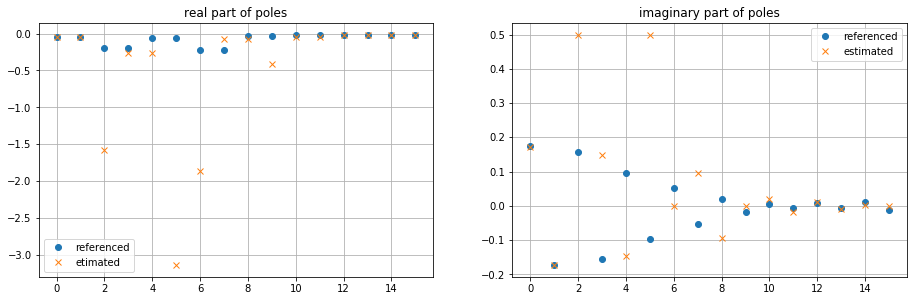

In [19]:
plt.figure(figsize=[40/2.57, 12/2.57])
plt.subplot(1,2,1)
plt.plot(np.real(log_eig), 'o', label = 'referenced')
plt.plot(np.real(log_eig_hat), 'x', label = 'etimated')
plt.title('real part of poles')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.imag(log_eig)/(2*np.pi), 'o', label='referenced')
plt.plot(np.imag(log_eig_hat)/(2*np.pi), 'x', label='estimated')
plt.title('imaginary part of poles')
plt.legend()
plt.grid()

* Summary:
	* A part of estimated eigenvalue matches the corresponding eigenvalues, almost completely.
	* The other are apart from the referenced one.
	* There is a clear difference between matched and unmatched poles.

## A sub best case: Nhrz = 2^2, Nepoch = 2^11

In [20]:
cur.execute('''Select Result.model_file_path, Result.Nhidden, Data.lti_file_path,
    Training.Nepoch, Training.Nhrz
    from Result join Data join Training
    where Result.data_id = Data.id and Result.training_id = Training.id
    and Data.lti_file_path = (?)
    and Training.Nhrz = ?
    and Training.Nepoch = ?
    ''', ('./tmp/data_006.pk', 2**2, 2**11))
model_file_path, Nhidden, lti_file_path, _, _ = cur.fetchone()

* load model and data generator
* Calculate the estimated (matched) poles and the true one

In [21]:
with open(lti_file_path, "rb") as fp:
    data_generator = pickle.load(fp)
Ny = data_generator.Ny
Nu = data_generator.Nu
mdl = model001(Nhidden, Ny, Nu)
mdl.load_state_dict(torch.load(model_file_path))

_weight = mdl.xu2x.weight
weight = _weight.data.numpy()
A_hat = weight[:, :Nhidden]
A = data_generator.A

eig, _= np.linalg.eig(A)
eig_hat, _ = np.linalg.eig(A_hat)

log_eig = np.log(eig)
log_eig_hat = np.log(eig_hat)
log_eig_hat_matched = match_eig_dist_to_another(log_eig_hat, log_eig)

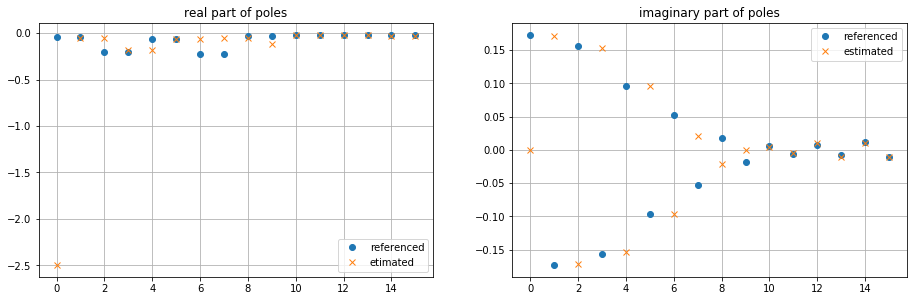

In [22]:
plt.figure(figsize=[40/2.57, 12/2.57])
plt.subplot(1,2,1)
plt.plot(np.real(log_eig), 'o', label = 'referenced')
plt.plot(np.real(log_eig_hat), 'x', label = 'etimated')
plt.title('real part of poles')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.imag(log_eig)/(2*np.pi), 'o', label='referenced')
plt.plot(np.imag(log_eig_hat)/(2*np.pi), 'x', label='estimated')
plt.title('imaginary part of poles')
plt.legend()
plt.grid()

* Summary:
	* A part of estimated eigenvalue matches the corresponding eigenvalues, almost completely.
	* The other are apart from the referenced one.
	* There is a clear difference between matched and unmatched poles.